## Housekeeping

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import curve_fit
import scipy.stats as stats

In [2]:
cd O:\TUD\__Arp-cortex\_____final-for-thesis\code\data

O:\TUD\__Arp-cortex\_____final-for-thesis\code\data


In [3]:
sns.set_context('talk')

# Load data

Load data (manual characterization done in Fiji and saved in excel table)

In [4]:
df = pd.read_csv('results_categorization_manual20220116.txt', sep='\t', decimal=",")
df.drop(columns=['Unnamed: 23'], inplace=True)
df.head(3)

,date,run,image,actin (uM),Arp type,VCA (uM),actin inside,cortex,flat patches,concave patches,...,loc spike,bouquet,inward tube,inward fuzz,membrane kinks,global deformation,dumbbell,dumbbell loc,inside patch,diameter (um)
0,20211114,1,20211114_run1_8uMactin_VCA5uM_00128_zstack_1um-5,8,B5L,5.0,1.0,1.0,0,0,...,0,0,1,1,0,1,0,0.0,0,13.000
1,20211114,1,20211114_run1_8uMactin_VCA5uM_00128_zstack_1um-4,8,B5L,5.0,1.0,1.0,0,0,...,0,0,1,0,0,1,0,0.0,0,14.161
2,20211114,1,20211114_run1_8uMactin_VCA5uM_00128_zstack_1um-3,8,B5L,5.0,1.0,1.0,0,0,...,0,0,0,1,0,0,0,0.0,0,14.637


# GUV sizes

Plot

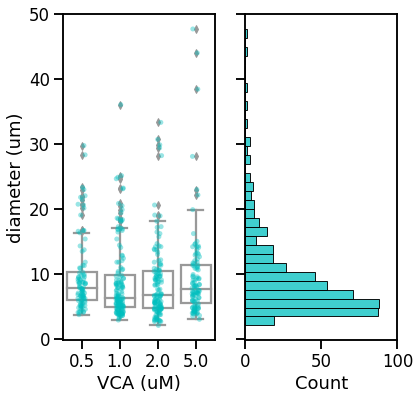

In [5]:
#f = plt.figure(figsize=[3, 7])
from matplotlib import gridspec

fig, ax =plt.subplots(nrows=1,ncols=2, figsize=[6,6]) 
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

sns.stripplot(data=df, x='VCA (uM)', y='diameter (um)', size=5, alpha=0.4, color='c', ax=ax[0])
sns.boxplot(data=df, x='VCA (uM)', y='diameter (um)',  color='white', ax=ax[0])
sns.histplot( data=df, y='diameter (um)', color='c',  ax=ax[1])

ax[1].set(ylabel=None)
ax[1].set(yticklabels=[])
ax[1].set_xlim(0,100)

fig.savefig('sizes-per-sample_narrow.png', dpi=300, bbox_inches='tight')

Mean and StDev of the distributions

In [6]:
df.groupby('run').mean()['diameter (um)']

run
1    9.543564
2    8.566971
3    8.640503
4    9.607041
Name: diameter (um), dtype: float64

In [7]:
df.groupby('run').std()['diameter (um)']

run
1    7.183329
2    5.873830
3    5.791001
4    5.616000
Name: diameter (um), dtype: float64

Statistical test: are the distribution means the same?

In [8]:
# stats f_oneway functions takes the groups as input and returns ANOVA F and p value
fvalue, pvalue = stats.f_oneway(df.loc[df['run']==1]['diameter (um)'], 
                                df.loc[df['run']==2]['diameter (um)'],
                                df.loc[df['run']==3]['diameter (um)'], 
                                df.loc[df['run']==4]['diameter (um)'])
print('p by ANOVA= '+str(pvalue))

p by ANOVA= 0.3876829568893929


# GUV classification

### empty GUVs

In [9]:
type_order = ['empty', '0.5 uM VCA', '1 uM VCA',  '2 uM VCA', '5 uM VCA']
VCA_order = ['none', 0.65, 1.3, 2.6, 6.5]

df['type'] = [ '' ]*len(df)

for ii in range(len(df)):
    #print(ii)
    
    if df['actin inside'][ii]==0:
        df['type'][ii]='empty'
        
    elif df['VCA (uM)'][ii]==0.5:
        df['type'][ii]='0.5 uM VCA'

    elif df['VCA (uM)'][ii]==1:
        df['type'][ii]='1 uM VCA'
        
    elif df['VCA (uM)'][ii]==2:
        df['type'][ii]='2 uM VCA'
        
    elif df['VCA (uM)'][ii]==5:
        df['type'][ii]='5 uM VCA'


<ipython-input-9-dfc365c7a349>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'][ii]='5 uM VCA'
<ipython-input-9-dfc365c7a349>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'][ii]='empty'
<ipython-input-9-dfc365c7a349>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'][ii]='2 uM VCA'
<ipython-input-9-dfc365c7a349>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

In [10]:
print('All GUVs:')

for type in ['empty', '0.5 uM VCA', '1 uM VCA', '2 uM VCA', '5 uM VCA']:
    print(type + ': ' + str(len(df.loc[df['type'] == type])))

print(len(df))

All GUVs:
empty: 60
0.5 uM VCA: 85
1 uM VCA: 129
2 uM VCA: 121
5 uM VCA: 99
494


### generalized protrusions

In [11]:
df['spike/nose'] = [ 0 ]*len(df)

for ii in range(len(df)):
    
    if df['outward spikes'][ii]==1 :
        df['spike/nose'][ii]=1

<ipython-input-11-1a50537ce3fd>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['spike/nose'][ii]=1


In [12]:
df['protrusion'] = [ 0 ]*len(df)

for ii in range(len(df)):
    
    if df['outward tubes'][ii]==1 or df['spike/nose'][ii]==1 :
        df['protrusion'][ii]=1

<ipython-input-12-b862e600de9c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['protrusion'][ii]=1


In [13]:
#What do I want to know? 

interests = pd.DataFrame(
    [['type', 'protrusion', 'all', -1],
    ['type', 'protrusion', 'cortex', 1], 
     ['type', 'protrusion', 'cortex', 0], 
     ['type', 'outward tubes', 'all', -1], 
     ['type', 'outward tubes', 'cortex', 1], 
     ['type', 'outward tubes', 'cortex', 0],
     ['type', 'outward spikes', 'all', -1],
     ['type', 'outward spikes', 'cortex', 1], 
     ['type', 'outward spikes', 'cortex', 0],
     ['type', 'membrane kinks', 'all', -1],
     ['type', 'membrane kinks', 'cortex', 1], 
     ['type', 'membrane kinks', 'cortex', 0],
     ['type', 'bouquet', 'all', -1], 
     ['type', 'bouquet', 'protrusion', 1], 
     ['type', 'bouquet', 'protrusion', 0], 
     ['type', 'global deformation', 'all', -1], 
     ['type', 'global deformation', 'cortex', 1], 
     ['type', 'global deformation', 'cortex', 0],
     ['type', 'cortex', 'all', -1],
     ['type', 'cortex', 'actin inside', 1], 
     ['type', 'cortex', 'actin inside', 0],
     ['type', 'inward fuzz', 'all', -1],
     ['type', 'inward fuzz', 'actin inside', 1], 
     ['type', 'inward fuzz', 'actin inside', 0],
     ['type', 'spike/nose', 'all', -1],
     ['type', 'spike/nose', 'actin inside', 1], 
     ['type', 'spike/nose', 'actin inside', 0],
    ], 
    columns=['group', 'characteristic', 'condition', 'condition value'])

#interests

In [14]:
df_statistics = pd.DataFrame(columns=["type", 
                                      "% of GUVs", 
                                      "phenotype", 
                                      "condition", 
                                      "condition value", 
                                      "count"])

for ii in range(len(interests)):
    
    # define the measurement
    GROUP = interests['group'][ii]
    CHAR = interests['characteristic'][ii]
    COND = interests['condition'][ii]
    COND_value = interests['condition value'][ii]
    
    if COND == 'all':
        # calculate prevalence of phenotype for each group (no preconditions)
        df_temp = df.groupby(GROUP)[CHAR].value_counts(normalize=True)*100
        df_temp = df_temp.to_frame(name='% of GUVs').reset_index()
        df_temp = df_temp.loc[ df_temp[CHAR] == 1]
        
        df_temp[ "condition" ] = [ COND ]*len(df_temp)
        df_temp[ "condition value" ] = [ COND_value ]*len(df_temp)

        # sample sizes for each group
        nobs = df.groupby([GROUP])[CHAR].agg(['count'])
        
    else:
        # calculate prevalence of phenotype for each group (under the condition)
        df_temp = df.loc[df[COND]==COND_value].groupby(GROUP)[CHAR].value_counts(normalize=True)*100
        df_temp = df_temp.to_frame(name='% of GUVs').reset_index()
        df_temp = df_temp.loc[ df_temp[CHAR] == 1]


        df_temp[ "condition" ] = [ COND ]*len(df_temp)
        df_temp[ "condition value" ] = [ COND_value ]*len(df_temp)

        # sample sizes for each group
        nobs = df.loc[df[COND]==COND_value].groupby([GROUP])[CHAR].agg(['count'])
    
    df_temp[ "phenotype" ]= CHAR
    
    # make the dataframe nice
    df_temp = df_temp.join(nobs, on=GROUP , how='outer')
    df_temp.drop(columns=CHAR, inplace=True)
    
    # bring different measurements together
    df_statistics = pd.concat([df_statistics, df_temp])#.reset_index()
    
df_statistics

,type,% of GUVs,phenotype,condition,condition value,count
1.0,0.5 uM VCA,5.882353,protrusion,all,-1,85
3.0,1 uM VCA,44.186047,protrusion,all,-1,129
5.0,2 uM VCA,48.760331,protrusion,all,-1,121
7.0,5 uM VCA,45.454545,protrusion,all,-1,99
9.0,empty,1.666667,protrusion,all,-1,60
...,...,...,...,...,...,...
1,0.5 uM VCA,1.388889,spike/nose,actin inside,1,72
3,1 uM VCA,9.909910,spike/nose,actin inside,1,111
5,2 uM VCA,13.861386,spike/nose,actin inside,1,101
7,5 uM VCA,8.045977,spike/nose,actin inside,1,87


In [15]:
df_statistics['VCA (uM)'] = ['']*len(df_statistics)
df_statistics.loc[df_statistics['type']=='empty', 'VCA (uM)'] = 'none'
df_statistics.loc[df_statistics['type']=='0.5 uM VCA', 'VCA (uM)'] = 0.65
df_statistics.loc[df_statistics['type']=='1 uM VCA', 'VCA (uM)'] = 1.3
#df_statistics.loc[df_statistics['type']=='1.5 uM VCA', 'VCA (uM)'] = 2
df_statistics.loc[df_statistics['type']=='2 uM VCA', 'VCA (uM)'] = 2.6
df_statistics.loc[df_statistics['type']=='5 uM VCA', 'VCA (uM)'] = 6.5
df_statistics

,type,% of GUVs,phenotype,condition,condition value,count,VCA (uM)
1.0,0.5 uM VCA,5.882353,protrusion,all,-1,85,0.65
3.0,1 uM VCA,44.186047,protrusion,all,-1,129,1.3
5.0,2 uM VCA,48.760331,protrusion,all,-1,121,2.6
7.0,5 uM VCA,45.454545,protrusion,all,-1,99,6.5
9.0,empty,1.666667,protrusion,all,-1,60,none
...,...,...,...,...,...,...,...
1,0.5 uM VCA,1.388889,spike/nose,actin inside,1,72,0.65
3,1 uM VCA,9.909910,spike/nose,actin inside,1,111,1.3
5,2 uM VCA,13.861386,spike/nose,actin inside,1,101,2.6
7,5 uM VCA,8.045977,spike/nose,actin inside,1,87,6.5


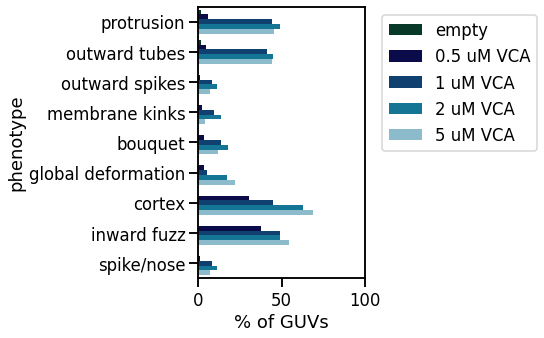

In [16]:
df_filtered = df_statistics.loc[df_statistics['condition']=='all']

prot = ['outward tubes', 'spike/nose', 'bouquet']

df_protrusions = df_filtered.loc[df_filtered['phenotype'].isin(prot)]
#df_filtered = df_statistics.loc[df_statistics['condition']=='all']

df_protrusions

f = plt.figure(figsize=[3,5])
ax = sns.barplot( data = df_filtered,
                x = '% of GUVs',
                y = 'phenotype',
                hue = 'type',
                hue_order=type_order,
                palette = 'ocean')

ax.legend( bbox_to_anchor=(1.05, 1), loc=2 ) #, title='VCA (uM)')
ax.set_xlim([0,100])
#ax.set_title(TITLE)

plt.show()

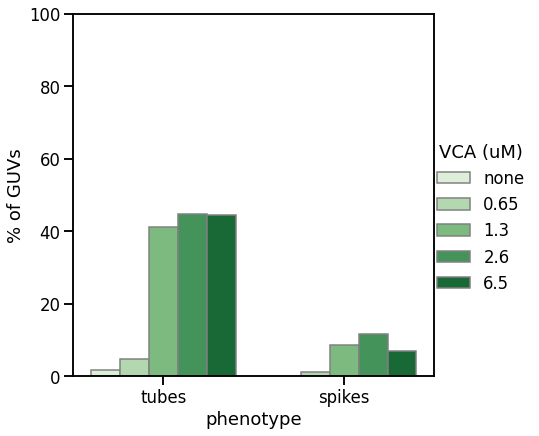

In [17]:
#f = plt.figure(figsize=[1, 2])
ax = sns.catplot(data=df_protrusions, x='phenotype', 
                 y='% of GUVs', hue='VCA (uM)', hue_order = VCA_order ,
                 order=['outward tubes','spike/nose'],#,'bouquet'],
                 height=6,
             col=None, kind='bar', palette='Greens',edgecolor="grey").despine(right=False, top=False)

ax.set(ylim=[0,100])
ax.set_xticklabels(['tubes', 'spikes'])#, 'bouquets'])

ax.savefig('protrusions-vs-VCA_box.png', dpi=300, bbox_inches='tight')

In [18]:
df_bouquets = df_statistics.loc[df_statistics['condition']=='protrusion']
df_bouquets

,type,% of GUVs,phenotype,condition,condition value,count,VCA (uM)
0.0,0.5 uM VCA,60.000000,bouquet,protrusion,1,5,0.65
3.0,1 uM VCA,31.578947,bouquet,protrusion,1,57,1.3
5.0,2 uM VCA,37.288136,bouquet,protrusion,1,59,2.6
7.0,5 uM VCA,26.666667,bouquet,protrusion,1,45,6.5


In [19]:
df_protrusions['VCA (uM)'] = ['']*len(df_protrusions)
df_protrusions.loc[df_protrusions['type']=='empty', 'VCA (uM)'] = 'none'
df_protrusions.loc[df_protrusions['type']=='0.5 uM VCA', 'VCA (uM)'] = 0.65
df_protrusions.loc[df_protrusions['type']=='1 uM VCA', 'VCA (uM)'] = 1.3
df_protrusions.loc[df_protrusions['type']=='2 uM VCA', 'VCA (uM)'] = 2.6
df_protrusions.loc[df_protrusions['type']=='5 uM VCA', 'VCA (uM)'] = 6.5
df_protrusions

<ipython-input-19-3fbff0c7d5ec>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_protrusions['VCA (uM)'] = ['']*len(df_protrusions)
C:\Users\LBaldauf\Anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


,type,% of GUVs,phenotype,condition,condition value,count,VCA (uM)
1.0,0.5 uM VCA,4.705882,outward tubes,all,-1,85,0.65
3.0,1 uM VCA,41.085271,outward tubes,all,-1,129,1.3
5.0,2 uM VCA,44.628099,outward tubes,all,-1,121,2.6
7.0,5 uM VCA,44.444444,outward tubes,all,-1,99,6.5
9.0,empty,1.666667,outward tubes,all,-1,60,none
1.0,0.5 uM VCA,3.529412,bouquet,all,-1,85,0.65
3.0,1 uM VCA,13.953488,bouquet,all,-1,129,1.3
5.0,2 uM VCA,18.181818,bouquet,all,-1,121,2.6
7.0,5 uM VCA,12.121212,bouquet,all,-1,99,6.5
1.0,0.5 uM VCA,1.176471,spike/nose,all,-1,85,0.65


### What fraction of protruded vesicles have actin localized at the base of a protrusion?

In [20]:
len(df)

494

In [21]:
len(df.loc[(df['actin inside']!=0) & (df['protrusion']==1)])

166

In [22]:
len(df.loc[(df['actin inside']!=0) & (df['protrusion']==1) & ( (df['loc tube']==1) | (df['loc spike']==1))])

125

In [23]:
len(df.loc[ (df['actin inside']==1) & (df['protrusion']==1) & ( (df['loc tube']==1) | (df['loc spike']==1))])/len(df.loc[(df['actin inside']==1) & (df['protrusion']==1)])

0.7792207792207793

In [24]:
len(df.loc[ (df['actin inside']==1) & (df['protrusion']==1) & ( (df['loc tube']==1) | (df['loc spike']==1))])

120

In [25]:
len(df.loc[(df['actin inside']==1) & (df['protrusion']==1)])

154

# Characterizing protrusions

In [26]:
df = pd.read_csv('20220217_protrusion_measurements.txt', sep='\t', decimal=",")#, idx_col=None )
df['aspect ratio']=df['base width (um)']/df['length (um)']
df_cat = pd.read_csv('results_categorization_manual20220116.txt', sep='\t', decimal=",")#, idx_col=None )
df_cat.drop(columns=['Unnamed: 23'], inplace=True)

df=pd.merge(df, df_cat,
    how="left", on=['image', 'date', 'run'], suffixes=("", ""))

df.columns

Index(['date', 'run', 'image', 'protrusion type', 'protrusion no',
       'in bouquet?', 'actin enriched?', 'membrane fuzz', 'length (um)',
       'base width (um)', 'aspect ratio', 'actin (uM)', 'Arp type', 'VCA (uM)',
       'actin inside', 'cortex', 'flat patches', 'concave patches',
       'outward tubes', 'loc tube', 'outward spikes', 'loc spike', 'bouquet',
       'inward tube', 'inward fuzz', 'membrane kinks', 'global deformation',
       'dumbbell', 'dumbbell loc', 'inside patch', 'diameter (um)'],
      dtype='object')

In [27]:
df['type']=['']*len(df)

for ii in range(len(df)):
   
    if df['actin inside'][ii]==0:
        df['type'][ii]='empty'
        
    elif df['VCA (uM)'][ii]==0.5:
        df['type'][ii]='0.65 uM VCA'

    elif df['VCA (uM)'][ii]==1:
        df['type'][ii]='1.3 uM VCA'
        
    elif df['VCA (uM)'][ii]==2:
        df['type'][ii]='2.6 uM VCA'
        
    elif df['VCA (uM)'][ii]==5:
        df['type'][ii]='6.5 uM VCA'

<ipython-input-27-a88218a021ad>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'][ii]='6.5 uM VCA'
<ipython-input-27-a88218a021ad>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'][ii]='2.6 uM VCA'
<ipython-input-27-a88218a021ad>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['type'][ii]='1.3 uM VCA'
<ipython-input-27-a88218a021ad>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


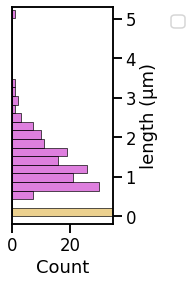

In [28]:
f = plt.figure(figsize=[1.8, 4])

ax=sns.histplot(data=df, y='base width (um)', bins = 30,#y='length (um)', 
                   #s=30, alpha=0.5,
                   hue='protrusion type', hue_order = ['tube', 'spike'],
                palette=['goldenrod', 'm'])

ax.legend( bbox_to_anchor=(1.5, 1), loc=2 )

ax.set_ylabel('length (\u03bcm)')

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


ax.set_ylim(-0.2,5.3)
ax.set_xlim(0,35)

fig = ax.get_figure()
fig.savefig('protrusion-width-histogram.png', dpi=300, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


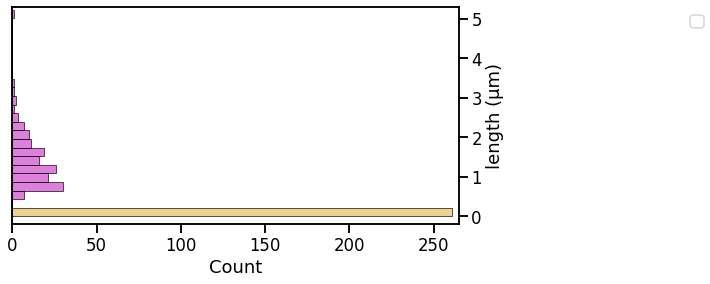

In [29]:
f = plt.figure(figsize=[8, 4])

ax=sns.histplot(data=df, y='base width (um)', bins = 30,#y='length (um)', 
                   #s=30, alpha=0.5,
                   hue='protrusion type', hue_order = ['tube', 'spike'],
                palette=['goldenrod', 'm'])

ax.legend( bbox_to_anchor=(1.5, 1), loc=2 )

ax.set_ylabel('length (\u03bcm)')

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


ax.set_ylim(-0.2,5.3)
ax.set_xlim(0,265)

fig = ax.get_figure()
fig.savefig('protrusion-width-histogram_long.png', dpi=300, bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


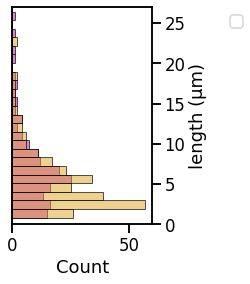

In [30]:
f = plt.figure(figsize=[2.5, 4])

ax=sns.histplot(data=df, y='length (um)', bins = 30,#y='length (um)', 
                   #s=30, alpha=0.5,
                   hue='protrusion type', hue_order = ['tube', 'spike'],
                palette=['goldenrod', 'm'])

ax.legend( bbox_to_anchor=(1.5, 1), loc=2 )

ax.set_ylabel('length (\u03bcm)')

ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")


ax.set_ylim(0,27)

fig = ax.get_figure()
fig.savefig('protrusion-length-histogram.png', dpi=300, bbox_inches='tight')

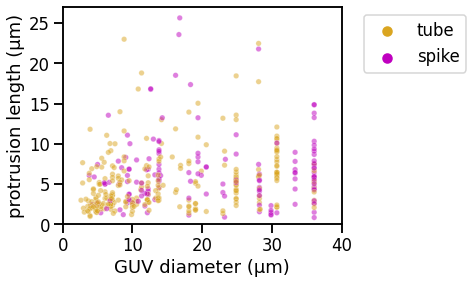

In [31]:
f = plt.figure(figsize=[5, 4])

ax=sns.scatterplot(data=df, x='diameter (um)', y='length (um)', 
                   s=30, alpha=0.5,
                   hue='protrusion type', palette=['goldenrod', 'm'])
ax.legend( bbox_to_anchor=(1.05, 1), loc=2 )
ax.set_xlabel('GUV diameter (\u03bcm)')
ax.set_ylabel('protrusion length (\u03bcm)')

ax.set_xlim(0,40)
ax.set_ylim(0,27)

fig = ax.get_figure()
fig.savefig('protrusion-length_vs-GUVsize.png', dpi=300, bbox_inches='tight')

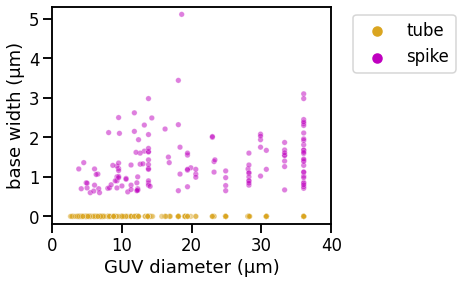

In [32]:
f = plt.figure(figsize=[5, 4])

ax=sns.scatterplot(data=df, x='diameter (um)', y='base width (um)', 
                   s=30, alpha=0.5,
                   hue='protrusion type', palette=['goldenrod', 'm']) #palette='Greens', 
                   #hue_order=['empty', '0.65 uM VCA', '1.3 uM VCA', '2.6 uM VCA', '6.5 uM VCA'])
ax.set_xlabel('GUV diameter (\u03bcm)')
ax.set_ylabel('base width (\u03bcm)')
ax.legend( bbox_to_anchor=(1.05, 1), loc=2 )


ax.set_xlim(0,40)
ax.set_ylim(-0.2,5.3)


fig = ax.get_figure()
fig.savefig('protrusion-base_vs-GUVsize.png', dpi=300, bbox_inches='tight')

In [33]:
print('N tubes: ', len(df.loc[(df['protrusion type']=='tube')]))
print('N spikes: ', len(df.loc[(df['protrusion type']=='spike')]))

N tubes:  261
N spikes:  157


In [34]:
df_inbouquet = pd.DataFrame(index=np.arange(2), columns=['protrusion', '% in bouquet', 'N'])
df_inbouquet.iloc[0]=['tube', 
                      100*df.groupby('protrusion type').sum()['in bouquet?']['tube']/len(df.loc[df['protrusion type']=='tube']),
                      len(df.loc[df['protrusion type']=='tube'])]
df_inbouquet.iloc[1]=['spike', 
                      100*df.groupby('protrusion type').sum()['in bouquet?']['spike']/len(df.loc[df['protrusion type']=='spike']),
                      len(df.loc[df['protrusion type']=='spike'])]

df_inbouquet

,protrusion,% in bouquet,N
0,tube,60.1533,261
1,spike,56.051,157
